# Model Predictive Control (MPC) - Applications
### Notebook 3 of 3: Interactive Exploration and Applications

---
In this notebook, we explore applications of MPC and make the concepts interactive.

We will cover:
- Interactive sliders for $Q, R, N$
- Application sketches (autonomous driving, process control)
- Exercises for scenario analysis
- Summary and key takeaways


## 1. Interactive Sliders

We use `ipywidgets` to vary $Q, R$, and horizon $N$ interactively and observe the effect on the MPC trajectory.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import scipy.linalg as la
import ipywidgets as widgets
from ipywidgets import interact

A = np.array([[1,1],[0,1]])
B = np.array([[0],[1]])

def simulate_mpc(Q_weight=1.0, R_weight=1.0, N=10):
    Q = Q_weight*np.eye(2)
    R = R_weight*np.array([[1]])
    P = la.solve_discrete_are(A,B,Q,R)
    
    umin, umax = -0.5, 0.5
    x0 = np.array([[5],[0]])
    T = 30
    x = x0.copy()
    x_hist, u_hist = [], []
    for t in range(T):
        X = cp.Variable((2, N+1))
        U = cp.Variable((1, N))
        cost = 0
        constraints = [X[:,0] == x[:,0]]
        for k in range(N):
            cost += cp.quad_form(X[:,k], Q) + cp.quad_form(U[:,k], R)
            constraints += [X[:,k+1] == A@X[:,k] + B@U[:,k]]
            constraints += [U[:,k] <= umax, U[:,k] >= umin]
        cost += cp.quad_form(X[:,N], P)
        prob = cp.Problem(cp.Minimize(cost), constraints)
        prob.solve()
        u_opt = U[:,0].value
        x = A@x + B@u_opt
        x_hist.append(x.flatten())
        u_hist.append(u_opt)
    x_hist = np.array(x_hist)
    u_hist = np.array(u_hist)
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(x_hist[:,0], label='Position')
    plt.plot(x_hist[:,1], label='Velocity')
    plt.legend(); plt.title('States')
    plt.subplot(1,2,2)
    plt.step(range(T), u_hist, label='Control')
    plt.legend(); plt.title('Control Input')
    plt.show()

interact(simulate_mpc, Q_weight=(0.1,10,0.5), R_weight=(0.1,10,0.5), N=(2,20,1));


interactive(children=(FloatSlider(value=1.0, description='Q_weight', max=10.0, min=0.1, step=0.5), FloatSlider…

### Exercise 1
- Increase $Q$: what happens to convergence speed?
- Increase $R$: what happens to smoothness of control?
- Reduce horizon $N$: does the system still stabilize?

### Exercise 1 - Solution
- Increase $Q$: faster convergence, larger control effort.  
- Increase $R$: smoother inputs, slower convergence.  
- Decrease horizon $N$: short-sighted control, possible instability.  


## 2. Application Sketch: Autonomous Driving (Lane Keeping)

We illustrate how MPC is used for **lane keeping**.
- State: lateral position, heading angle.
- Control: steering angle.
- Constraint: max steering.
- MPC predicts car motion and keeps within lane boundaries.


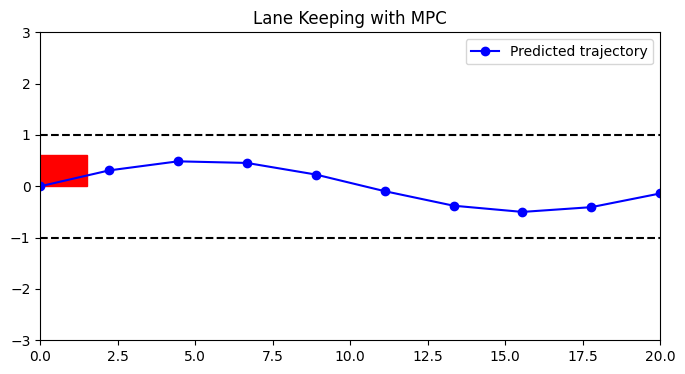

In [4]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,4))
ax.set_xlim(0,20)
ax.set_ylim(-3,3)

# Lane boundaries
ax.plot([0,20],[1,1],'k--')
ax.plot([0,20],[-1,-1],'k--')

# Vehicle predicted trajectory
x = np.linspace(0,20,10)
y = 0.5*np.sin(0.3*x)
ax.plot(x,y,'bo-',label='Predicted trajectory')

# Car representation
car = patches.Rectangle((0,0),1.5,0.6,fill=True,color='red')
ax.add_patch(car)

ax.set_title('Lane Keeping with MPC')
ax.legend()
plt.show()


### Exercise 2
- Imagine the lane becomes narrower (boundaries closer). How would MPC change its trajectory?
- What happens if steering constraints are too tight?

### Exercise 2 - Solution
- Narrower lane boundaries: MPC adjusts trajectory to remain feasible.  
- If steering constraints are too tight: optimization may become infeasible.  


## 3. Application Sketch: Industrial Process Control

Example: heating a furnace.
- State: temperature.
- Control: heater power.
- Constraint: power limited between 0 and 100%.
- MPC predicts future temperature and adjusts heater conservatively.


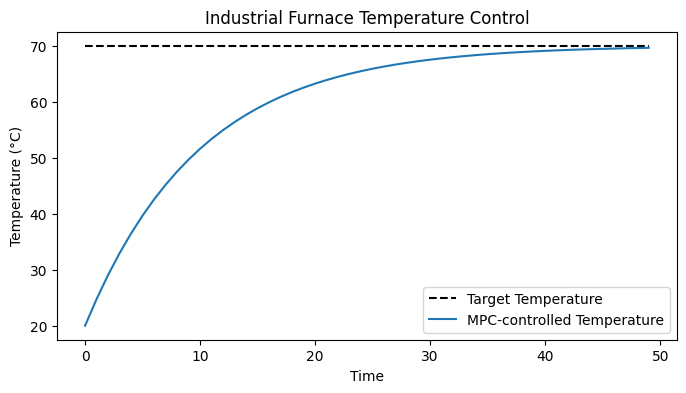

In [5]:
time = np.arange(0,50)
ref_temp = 70*np.ones_like(time)
temp = 20 + 50*(1-np.exp(-time/10))
plt.figure(figsize=(8,4))
plt.plot(time,ref_temp,'k--',label='Target Temperature')
plt.plot(time,temp,label='MPC-controlled Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Industrial Furnace Temperature Control')
plt.legend()
plt.show()


### Exercise 3
- If maximum heater power is reduced, what happens to rise time?
- How does MPC balance between fast heating and not overshooting?

### Exercise 3 - Solution
- Lower maximum heater power → slower rise time.  
- MPC balances heating speed vs avoiding overshoot.  



## 4. Summary & Takeaways

- **LQR**: optimal, but no constraints.
- **MPC**: powerful because it predicts, optimizes, and enforces constraints.
- Applications: autonomous driving, robotics, process control, energy systems.
- Tradeoff: computation vs flexibility.

👉 MPC is essentially "LQR with constraints + real-time optimization".
